Get all packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from functions import *
from tensorflow import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/mposternack/conda-envs/my-npl-tensor/share/proj failed
2025-04-16 12:03:43.363038: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 12:03:43.373801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744826623.384122  109668 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744826623.387415  109668 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744826623.396

In [4]:
dir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/psl/gn/files/d20190320'

In [10]:
ls /glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/psl/gn/files/d20190320

psl_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc*
psl_Amon_CESM2_piControl_r1i1p1f1_gn_010001-019912.nc*
psl_Amon_CESM2_piControl_r1i1p1f1_gn_020001-029912.nc*
psl_Amon_CESM2_piControl_r1i1p1f1_gn_030001-039912.nc*
psl_Amon_CESM2_piControl_r1i1p1f1_gn_040001-049912.nc*
psl_Amon_CESM2_piControl_r1i1p1f1_gn_050001-059912.nc*
psl_Amon_CESM2_piControl_r1i1p1f1_gn_060001-069912.nc*
psl_Amon_CESM2_piControl_r1i1p1f1_gn_070001-079912.nc*
psl_Amon_CESM2_piControl_r1i1p1f1_gn_080001-089912.nc*
psl_Amon_CESM2_piControl_r1i1p1f1_gn_090001-099912.nc*
psl_Amon_CESM2_piControl_r1i1p1f1_gn_100001-109912.nc*
psl_Amon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc*


In [11]:
psl_0 = xr.open_dataset(dir + '/psl_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc')
psl_1 = xr.open_dataset(dir + '/psl_Amon_CESM2_piControl_r1i1p1f1_gn_010001-019912.nc')
psl_2 = xr.open_dataset(dir + '/psl_Amon_CESM2_piControl_r1i1p1f1_gn_020001-029912.nc')
psl_3 = xr.open_dataset(dir + '/psl_Amon_CESM2_piControl_r1i1p1f1_gn_030001-039912.nc')
psl_4 = xr.open_dataset(dir + '/psl_Amon_CESM2_piControl_r1i1p1f1_gn_040001-049912.nc')


Load dataset from the directory discussed with Kirstin -- 500 years (monthwise data)

In [12]:
psl_all = xr.concat([psl_0, psl_1, psl_2, psl_3, psl_4], dim='time')

In [13]:
def deseasonalize(data):
    
    monthly_avg = data.groupby("time.month").mean()
    deseasonalized_data = data.groupby("time.month") - monthly_avg
    return deseasonalized_data

In [14]:
deseasonalized_data  =  deseasonalize(psl_all)

In [15]:
def composite_by_year(da):
    """
    Compute a 3-month composite using proper DJF (and cross‐year) averaging,
    but skip the first DJF (January composite of the first year) and the last NDJ
    (December composite of the last year), which are incomplete.
    For each month:
      - January: if not the first year, average previous December, current January, and current February.
      - December: if not the last year, average current November, current December, and next January.
      - All other months: average previous, current, and next month.
    Parameters
    ----------
    da : xarray.DataArray
        DataArray with a time dimension (named "valid_time") and monthly data.
        For example, shape could be (time=480, lat, lon) or just (time=480).
    Returns
    -------
    da_comp : xarray.DataArray
        Composite DataArray with dimensions ('year', 'month', …).
        Note that the first year will not have a January composite and
        the last year will not have a December composite.
    """
    # 1) Rename "valid_time" -> "time" to simplify
    if "valid_time" in da.dims:
        da = da.rename(valid_time="time")
    # 2) Create year and month coordinates from "time"
    da = da.assign_coords(
        year=da.time.dt.year,
        month=da.time.dt.month
    )
    # 3) Sort the data by time just to be sure
    da = da.sortby("time")
    # 4) Gather the unique years in ascending order
    years = np.sort(np.unique(da.year.values))
    comp_list_years = []
    for yi, year in enumerate(years):
        if year % 100 == 0:
            print(year)
        # Subset to the current year's data
        current = da.where(da.year == year, drop=True)
        comp_list_month = []
        for m in range(1, 13):
            # Skip the first January composite (incomplete DJF) for the first year
            if yi == 0 and m == 1:
                continue
            # Skip the last December composite (incomplete NDJ) for the last year
            if yi == len(years) - 1 and m == 12:
                continue
            if m == 1:
                # January composite (complete composite, requires previous December)
                dec_prev = da.where((da.year == years[yi - 1]) & (da.month == 12), drop=True)
                jan = current.where(current.month == 1, drop=True)
                feb = current.where(current.month == 2, drop=True)
                slices = xr.concat([dec_prev, jan, feb], dim="time")
            elif m == 12:
                # December composite (complete composite, requires next January)
                nov = current.where(current.month == 11, drop=True)
                dec = current.where(current.month == 12, drop=True)
                jan_next = da.where((da.year == years[yi + 1]) & (da.month == 1), drop=True)
                slices = xr.concat([nov, dec, jan_next], dim="time")
            else:
                # All other months: previous, current, and next
                slices = current.where(current.month.isin([m-1, m, m+1]), drop=True)
            # 5) Average over "time" to collapse the 2 or 3 months -> single composite
            comp = slices.mean(dim="time", skipna=True)
            # 6) Expand so that we have a 'month' dimension
            comp = comp.expand_dims(month=[m])
            comp_list_month.append(comp)
        # 7) Concatenate the monthly composites along 'month'
        comp_year = xr.concat(comp_list_month, dim="month")
        comp_year = comp_year.assign_coords(year=year)
        comp_list_years.append(comp_year)
    # 8) Concatenate over all years
    da_comp = xr.concat(comp_list_years, dim="year")
    return da_comp

In [16]:
try_again  = composite_by_year(deseasonalized_data)

100
200
300
400


In [17]:
djf_only = try_again.sel(month=1)
djf_only = djf_only.rename({'year': 'time'})
djf_only = djf_only.isel(time=slice(1, None)) 

In [23]:
north_atlantic_ocean_psl

<xarray.Dataset> Size: 14MB
Dimensions:   (lat: 64, time: 498, lon: 105, nbnd: 2)
Coordinates:
    month     int64 8B 1
  * lat       (lat) float64 512B 20.26 21.2 22.15 23.09 ... 77.75 78.69 79.63
  * time      (time) int64 4kB 2 3 4 5 6 7 8 9 ... 493 494 495 496 497 498 499
  * lon       (lon) float64 840B -90.0 -88.75 -87.5 -86.25 ... 37.5 38.75 40.0
Dimensions without coordinates: nbnd
Data variables:
    psl       (time, lat, lon) float32 13MB -2.13 -1.982 ... -2.774 -2.751
    lat_bnds  (time, lat, nbnd) float32 255kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lon_bnds  (time, lon, nbnd) float32 418kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

Deseasonalize, Standardize, and Slice along the ocean 

In [24]:
north_atlantic_ocean_psl = preprocess_na_ocean(djf_only) #changed this in functions
time_length, lat_length, long_length = get_lengths(north_atlantic_ocean_psl)
X_reshaped = north_atlantic_ocean_psl['psl'].values.reshape(time_length, lat_length * long_length, 1).astype('float32')
scaler = StandardScaler()
X_standardized_flat = scaler.fit_transform(X_reshaped.reshape(-1, 1))
X_standardized = X_standardized_flat.reshape(time_length, lat_length, long_length, 1)

converting to hecta pascals
deseasonalizing
slicing along lat=(20,80) and long=(-90,40)
time 498 lat 64 long 105


In [25]:
X_standardized.shape

(498, 64, 105, 1)

Add padding because otherwise the dimensions dont fit in a neural network

In [26]:
X_sliced = X_standardized[:, :, 4:100, :] 
long_length = 104
x_train, x_test = train_test_split(X_sliced, test_size=0.2) 

In [27]:
X_sliced.shape

(498, 64, 96, 1)

Check that the PCA still looks good even with modifications

______________
DOING PCA
covariance matrix shape (6144, 6144)
we calculated the first  10  evals
______________
PLOTTING EVALS


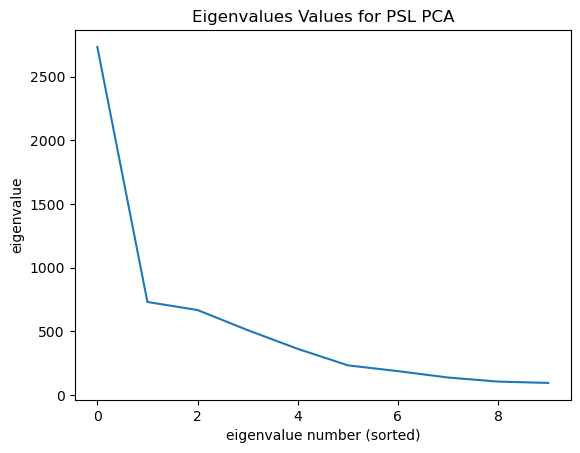

1 variance explained: 47.45%
2 variance explained: 12.68%
3 variance explained: 11.58%
4 variance explained: 8.84%
______________
PLOTTING TIME


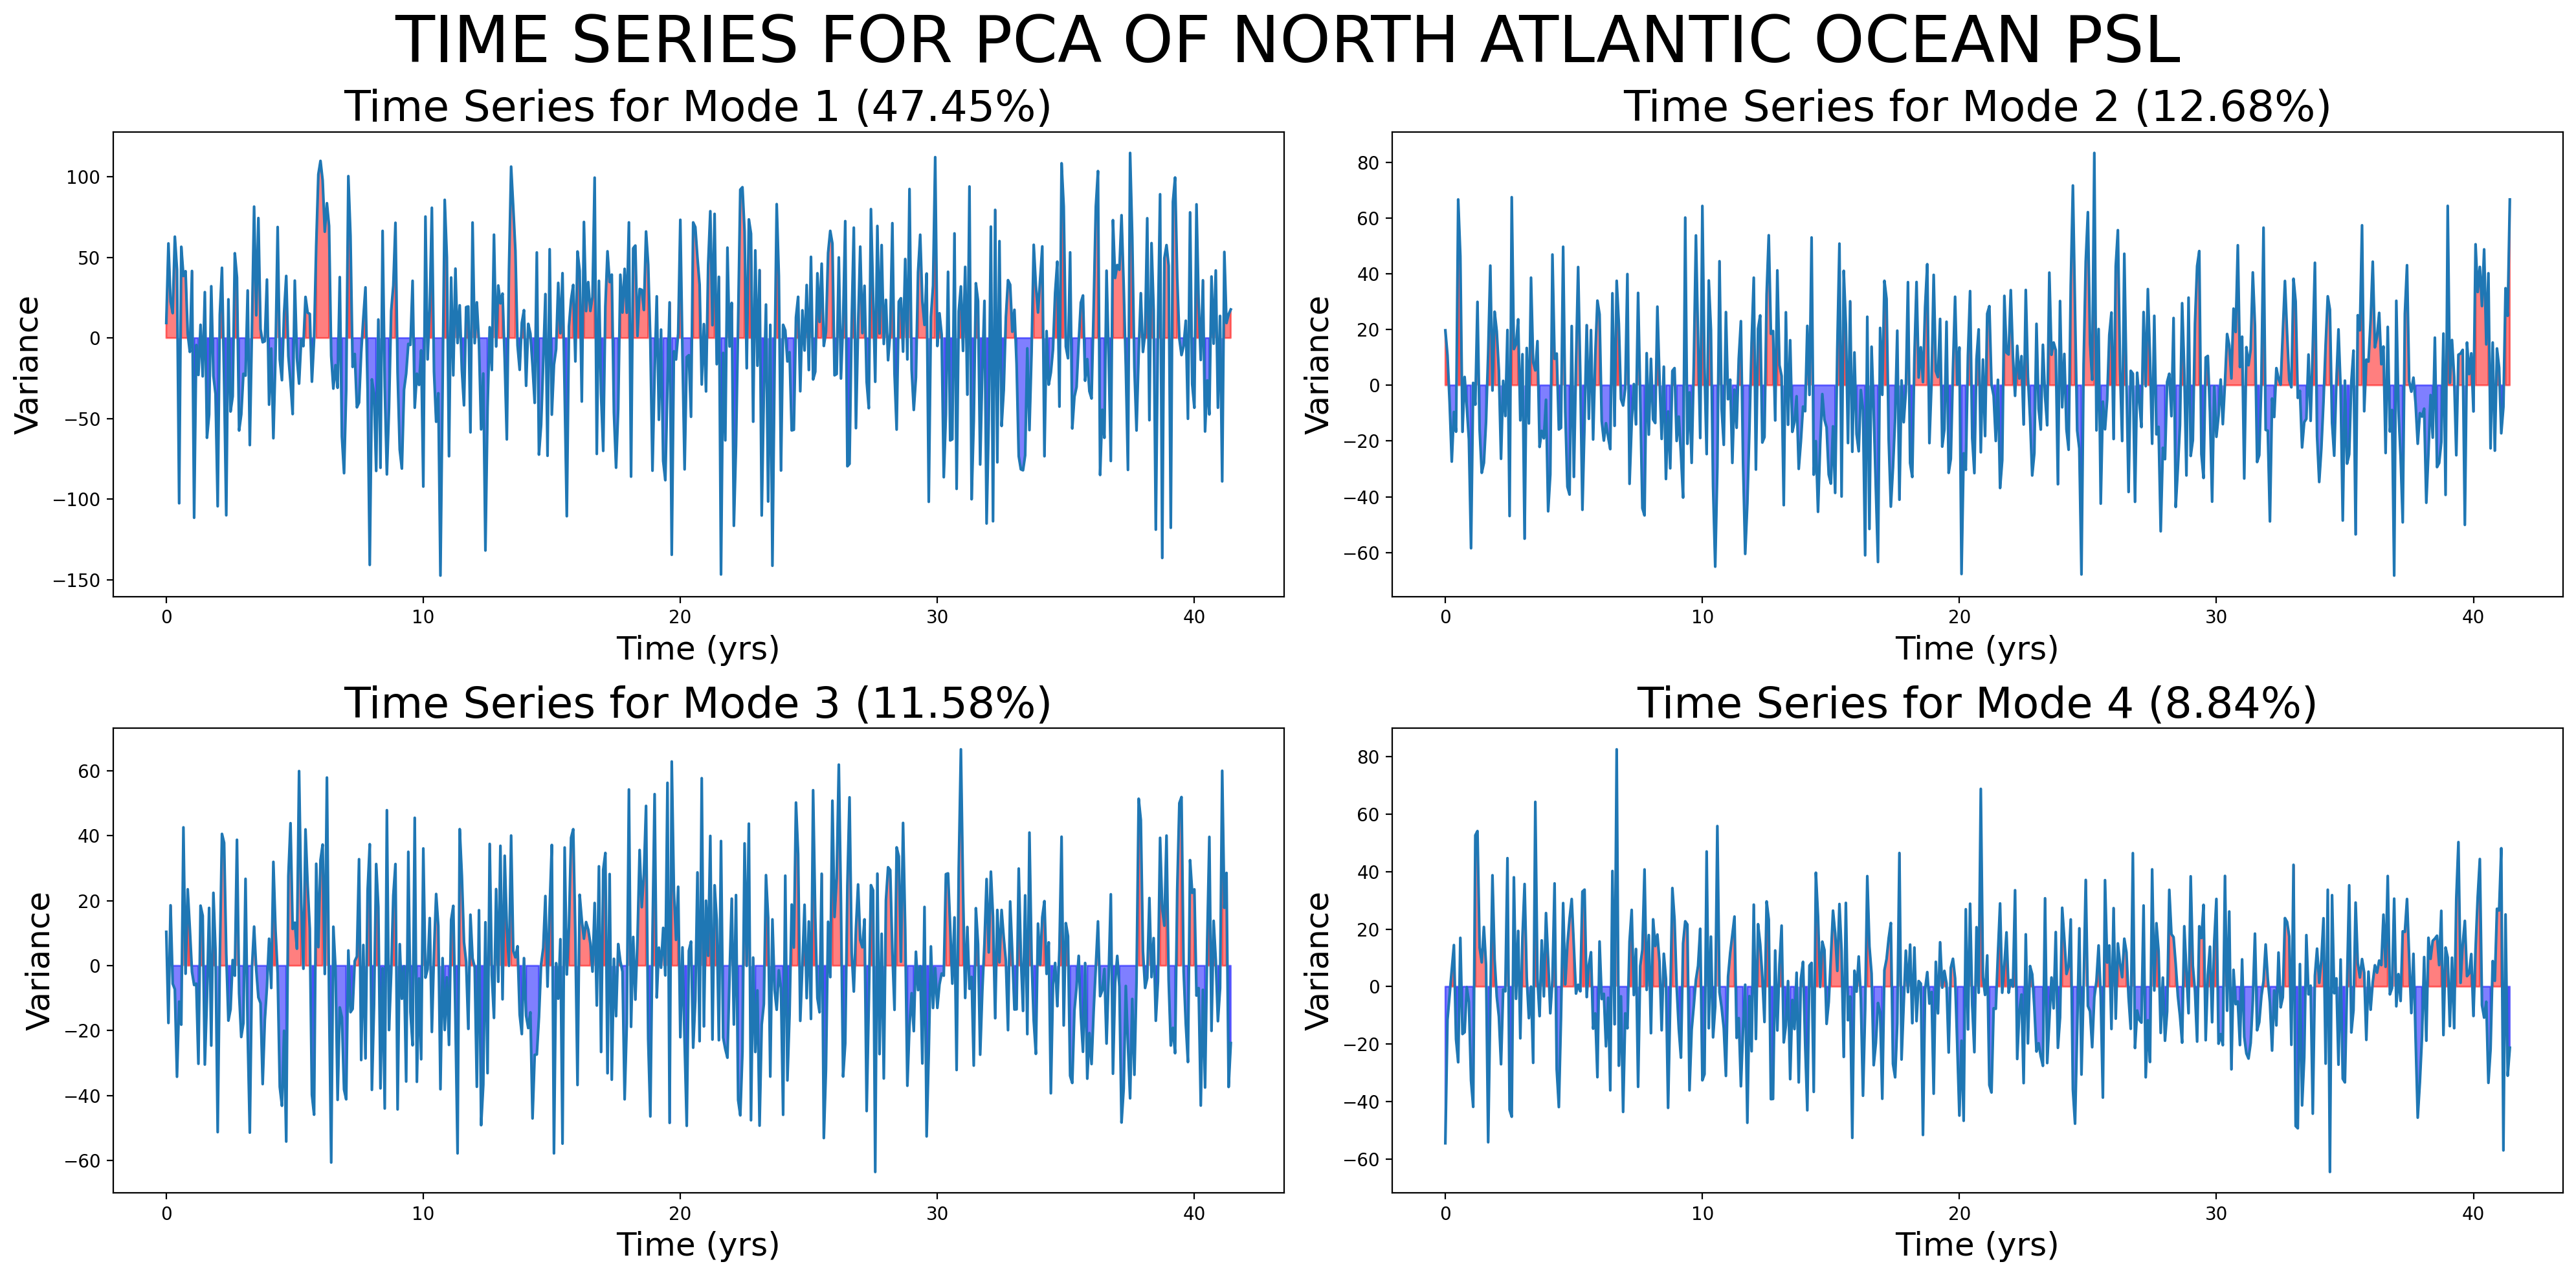

______________
PLOTTING PCs


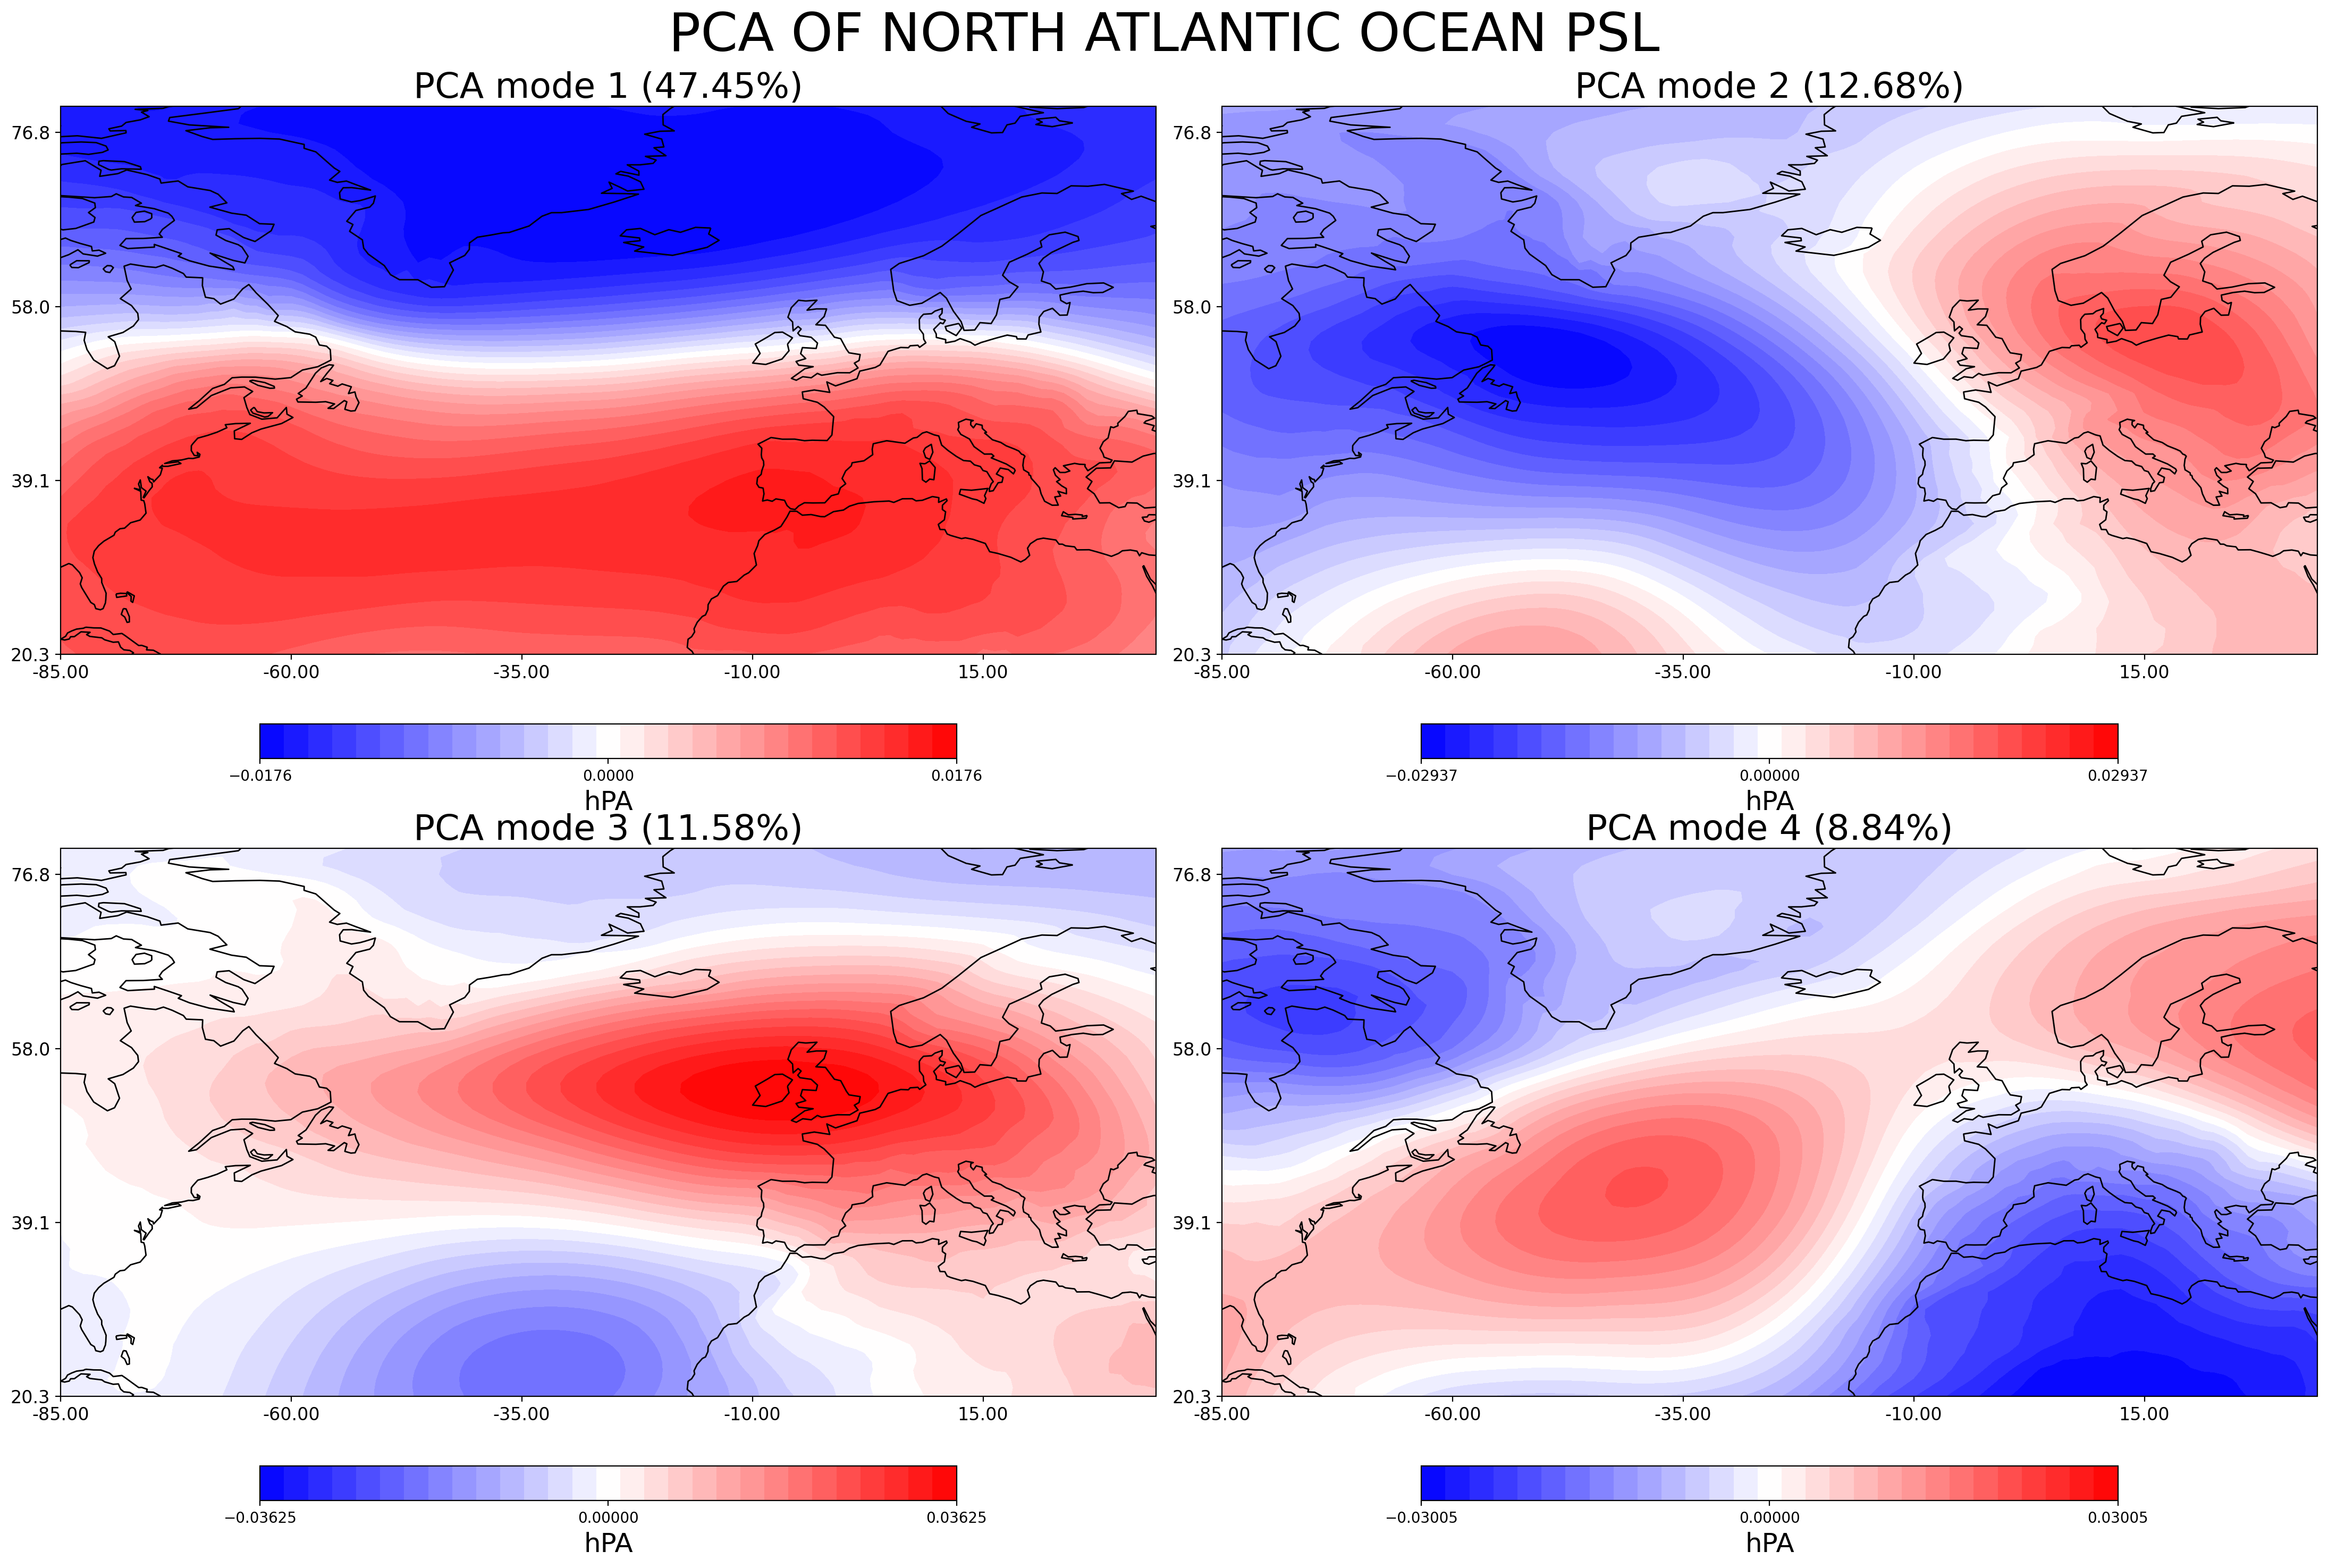

In [30]:
data_to_pca = X_sliced #x_padded, x_sliced, x_standardrizwd
time_length = data_to_pca.shape[0]
lat_length = data_to_pca.shape[1]
long_length = data_to_pca.shape[2]
X_dimensional = xr.DataArray(data_to_pca.reshape(time_length, lat_length * long_length))

print("______________")
print("DOING PCA")
X = standardize(X_dimensional)
X = X.T
eigenvalues, V, X = pca(X, 10, False)
print("______________")
print("PLOTTING EVALS")
perc_psl = plot_eigen(eigenvalues, "PSL")
print("______________")
print("PLOTTING TIME")
plot_time_series(V, X, 4, "TIME SERIES FOR PCA OF NORTH ATLANTIC OCEAN PSL", perc_psl)
print("______________")
print("PLOTTING PCs")
PCs_reshaped = V.reshape(lat_length,long_length, 10)
data_psl ={
    'reshaped_pca': PCs_reshaped,
    'original': north_atlantic_ocean_psl['psl'][:,:, 4:100], # make sure shape matches depending
    'label': "hPA",
    'shift': 0,
    'l_override': {},
    'perc': perc_psl
}

plot_pcs(data_psl, 4, "PCA OF NORTH ATLANTIC OCEAN PSL")

In [31]:
x_train.shape

(398, 64, 96, 1)

Run autoencoder

In [32]:
pool_size = (2,2)  # default
conv_size = (3,3)
rounds = [16,8,8,8]
epochs = 100  
learning_rate = 1e-4 
batch_size=128


In [33]:
input_img = keras.Input(shape=(lat_length, long_length, 1))

x = input_img
#encoding
for i in rounds:
    x = layers.Conv2D(i, conv_size, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size, padding='same')(x)

encoded = x

#decoding
for i in reversed(rounds):
    x = layers.Conv2D(i, conv_size, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(pool_size)(x)

x = layers.Conv2D(1, conv_size, activation='tanh', padding='same')(x) # final result

decoded = x


2025-04-16 12:16:02.390413: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

Initial Error

In [35]:
autoencoder.evaluate(x_train, x_train, batch_size=batch_size, verbose=0)

1.0255382061004639

Fit autoencoder using epochs defined above

In [36]:
autoencoder.fit(x_train, x_train,
                epochs=epochs, 
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[early_stopping, TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/100


2025-04-16 12:16:06.386705: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 1.0318 - val_loss: 0.9871
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 1.0547 - val_loss: 0.9844
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 1.0274 - val_loss: 0.9818
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 1.0089 - val_loss: 0.9789
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 1.0219 - val_loss: 0.9754
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.9928 - val_loss: 0.9711
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.9975 - val_loss: 0.9656
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 1.0145 - val_loss: 0.9585
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.9966 - val_loss: 0.9493
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 0.9847 - val_loss: 0.9375
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 0.9655 - val_loss: 0.9224
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.9564 - val_lo

Predict and depict images

In [38]:
decoded_imgs = autoencoder.predict(x_test)
scaler = StandardScaler()
decoded_flat = scaler.fit_transform(decoded_imgs.reshape(-1, 1))
decoded_standardized = decoded_flat.reshape(int(100), lat_length, long_length, 1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


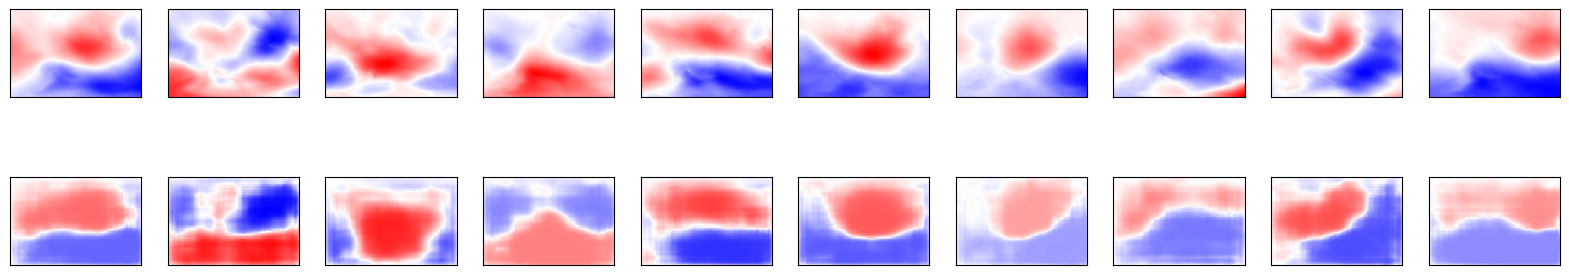

In [39]:
n = 10

fig=plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    max_value = np.max(np.abs(x_test[i]))

    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(lat_length, long_length), cmap='bwr', vmin=-max_value, vmax=max_value)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_standardized[i].reshape(lat_length, long_length),cmap='bwr', vmin=-max_value, vmax=max_value)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show(block=False)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


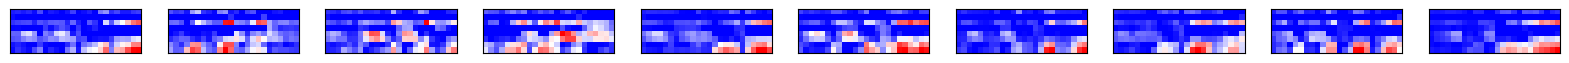

In [40]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

fig=plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    # Display latent space
    ax = plt.subplot(1, n, i)
    flat = encoded_imgs[i].reshape(-1, encoded_imgs.shape[-1])
    plt.imshow(flat.T, cmap='bwr')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


Compare sizes for scale

In [41]:
np.max(x_test), np.max(decoded_standardized)

(4.3287916, 1.5091343)

In [42]:
np.min(x_test), np.min(decoded_standardized)

(-4.5014887, -1.545166)

Confirm latent space ~10%

In [43]:
print("Latent space shape:", encoder.output_shape)

Latent space shape: (None, 4, 6, 8)


In [44]:
original_size = np.prod(x_test.shape[1:])  
latent_size = np.prod(encoded_imgs.shape[1:]) 
compression_ratio = latent_size / original_size

print(f"Compression ratio: {compression_ratio:.2%}")

Compression ratio: 3.12%


Now we cluster using kMeans

In [45]:
latent_vectors = encoded_imgs.reshape((encoded_imgs.shape[0], -1))

In [46]:
kmeans = KMeans(n_clusters=2)
cluster_labels = kmeans.fit_predict(latent_vectors)

Find the corresponding images in the original set (non-latent space)

In [47]:
cluster_0_indices = np.where(cluster_labels == 0)[0]
cluster_1_indices = np.where(cluster_labels == 1)[0]

cluster_0_images = x_test[cluster_0_indices]
cluster_1_images = x_test[cluster_1_indices]

Average the images

In [48]:
avg_img_0 = np.mean(cluster_0_images, axis=0) # weight by the cosine of thw latitude 
avg_img_1 = np.mean(cluster_1_images, axis=0)

avg0 = avg_img_0.squeeze()
avg1 = avg_img_1.squeeze()

We see the cluster averages perfectly map to NAO.

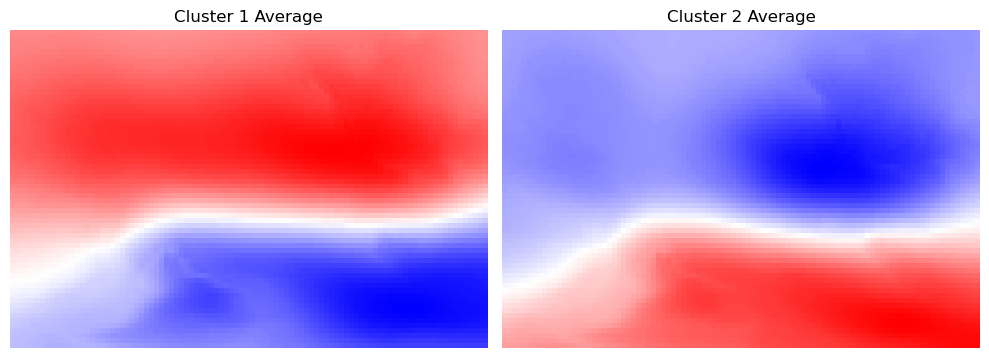

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(avg0, cmap='bwr')
axs[0].set_title("Cluster 1 Average")
axs[0].axis('off')

axs[1].imshow(avg1, cmap='bwr')
axs[1].set_title("Cluster 2 Average")
axs[1].axis('off')

plt.tight_layout()
plt.show()


Let's depict with coastlines to get context

In [51]:
original_data_shapes =  north_atlantic_ocean_psl['psl'][:,:, 4:100]
lats = original_data_shapes.lat.values
lons = original_data_shapes.lon.values

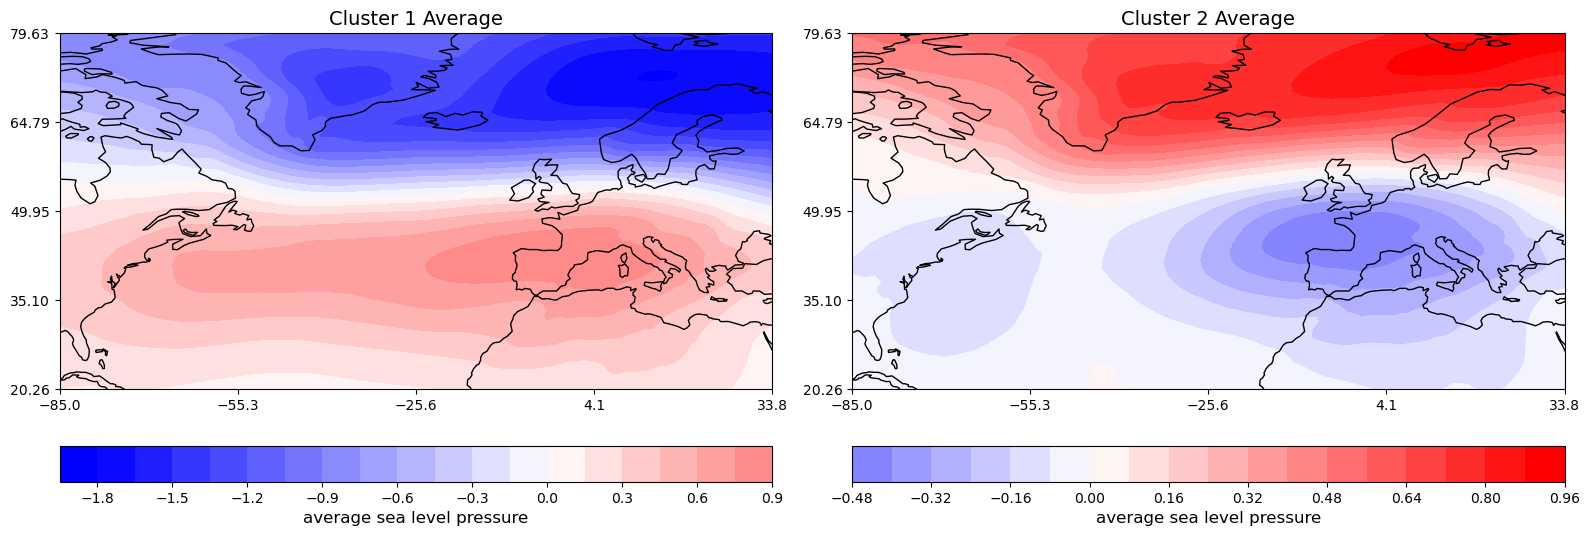

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree()})

for ax, avg, title in zip(axs, [avg0, avg1], ["Cluster 1 Average", "Cluster 2 Average"]):
    max_value = np.max(np.abs(avg))
    cf = ax.contourf(lons, lats, avg, cmap='bwr', levels=20, transform=ccrs.PlateCarree(),  vmin=-max_value, vmax=max_value)
    
    ax.coastlines()
    ax.set_title(title, fontsize=14)

    ax.set_xticks(np.linspace(lons.min(), lons.max(), 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(lats.min(), lats.max(), 5), crs=ccrs.PlateCarree())

    cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', pad=0.1)
    cbar.set_label("average sea level pressure", fontsize=12)


plt.tight_layout()
plt.show()


Compare to initial NAO

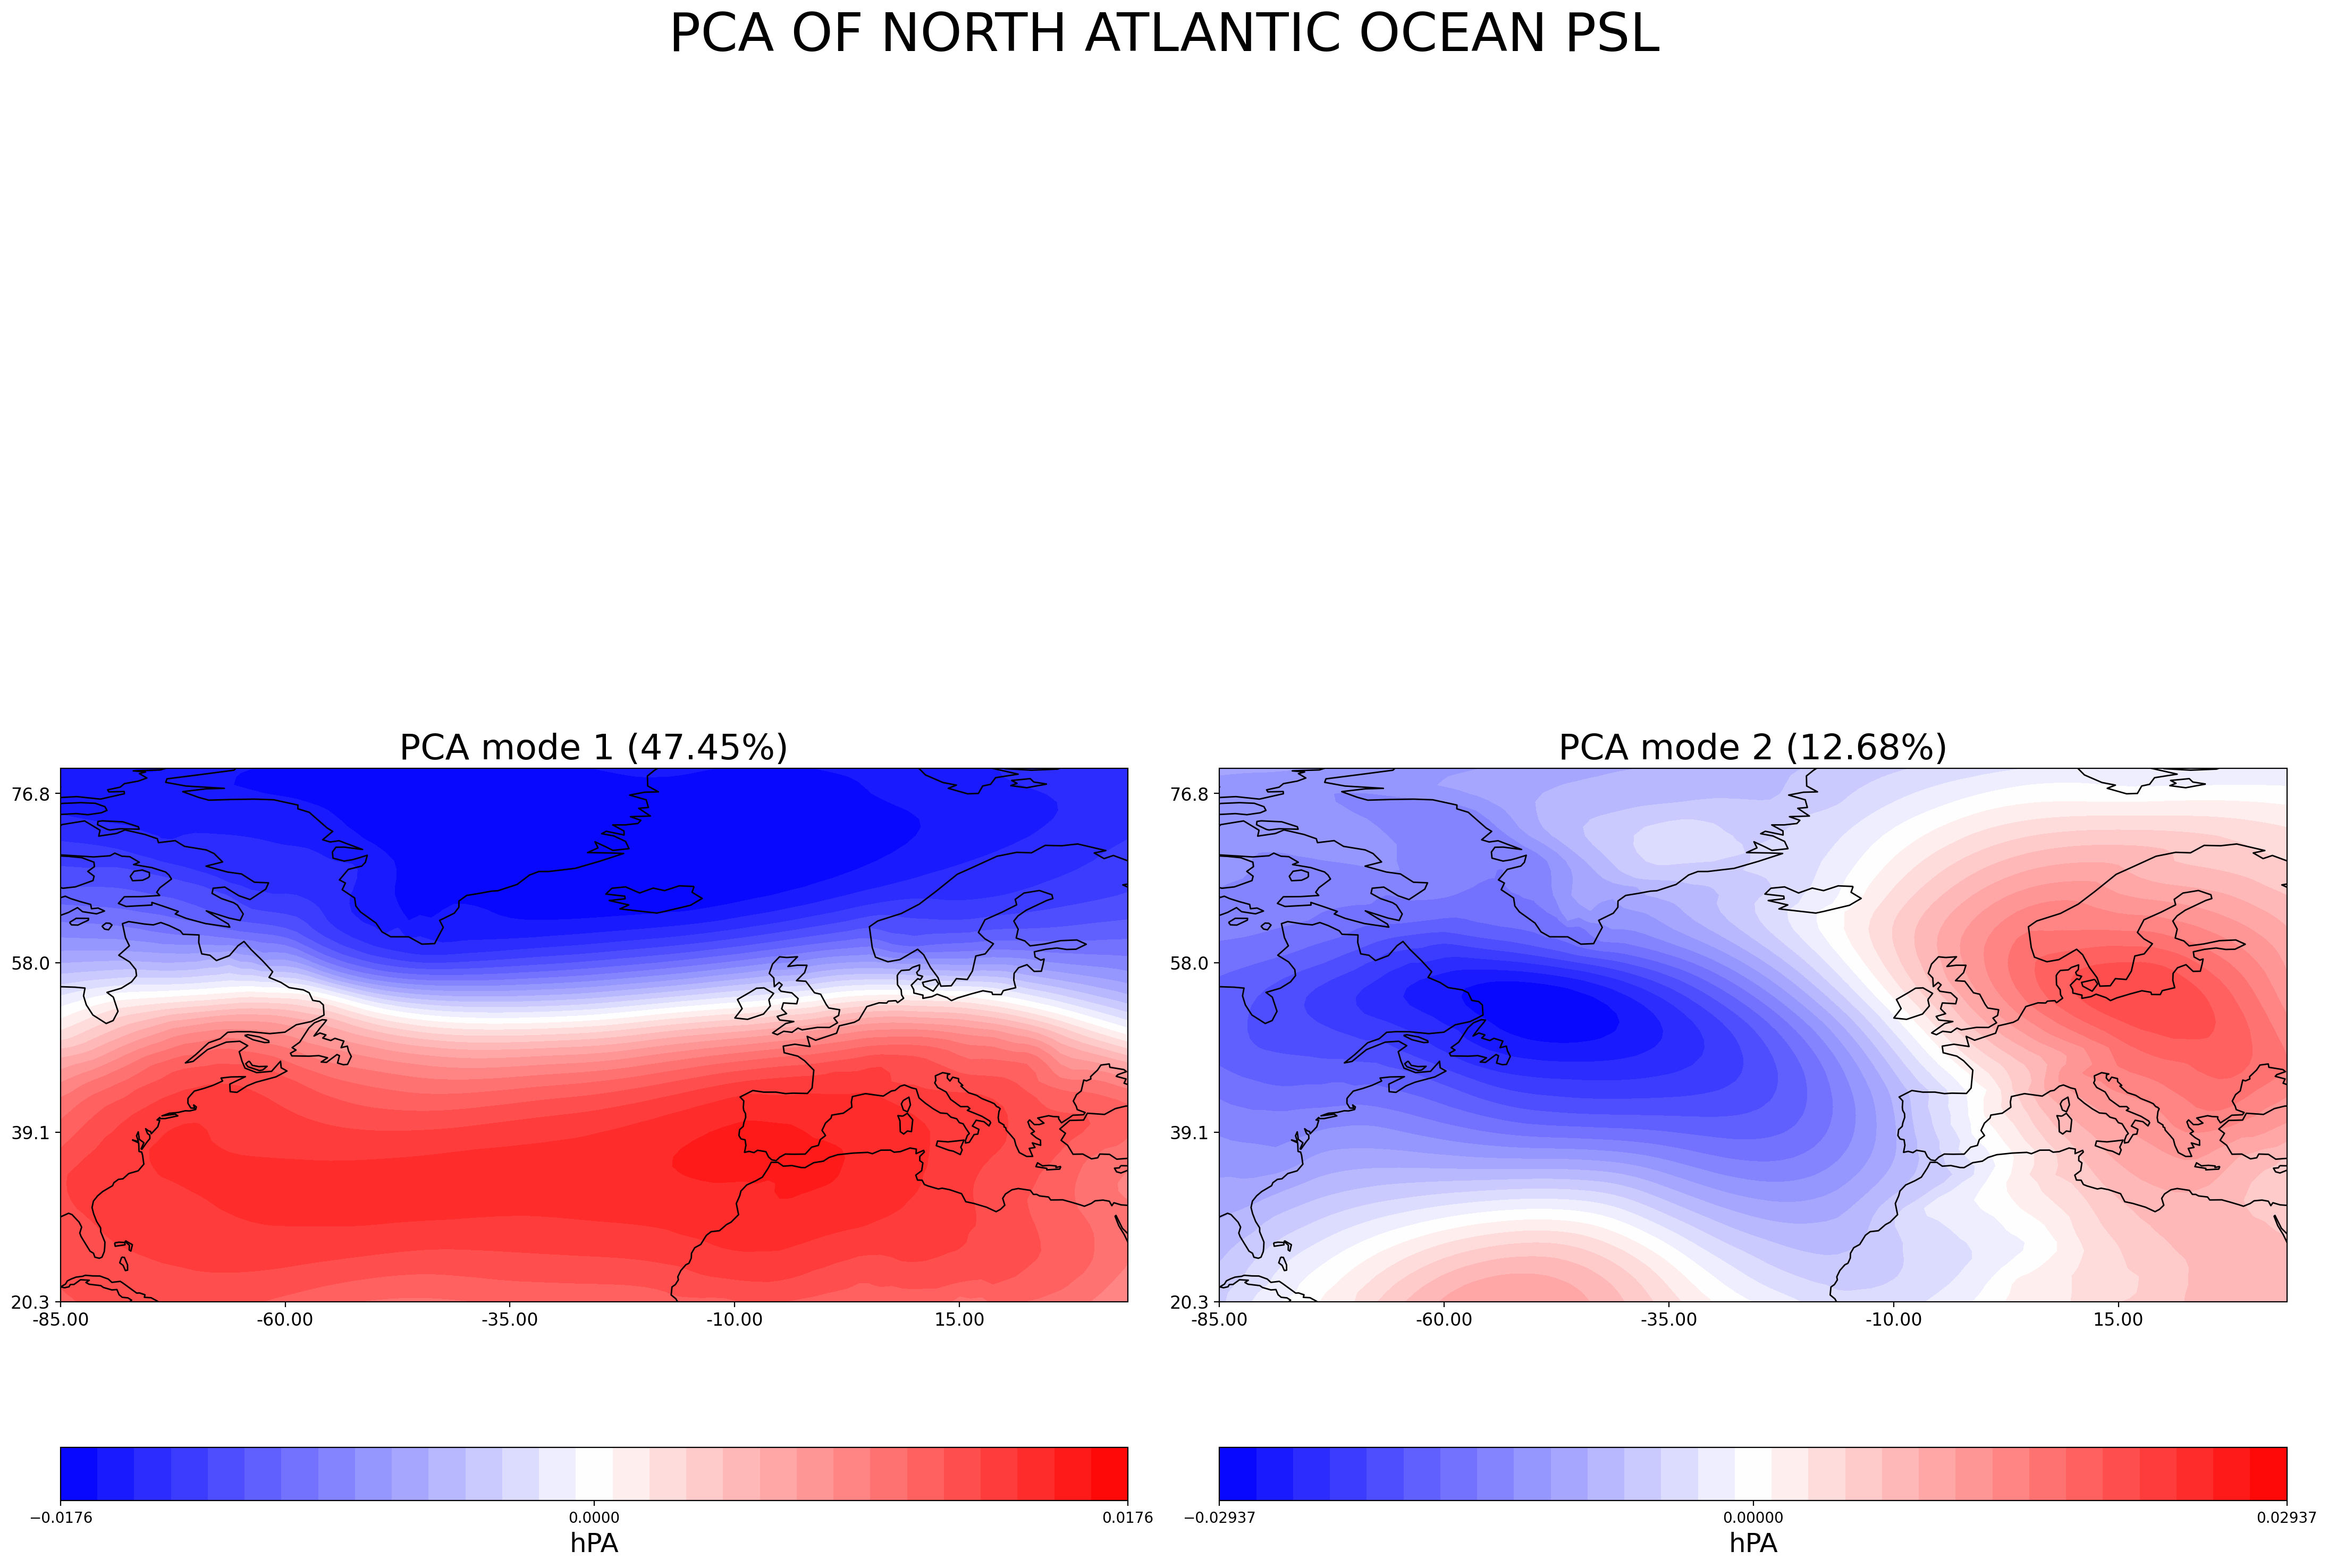

In [53]:
plot_pcs(data_psl, 2, "PCA OF NORTH ATLANTIC OCEAN PSL")